In [1]:
# the basics
import numpy as np
import pandas as pd
import os

# for statistics
from scipy.stats import mannwhitneyu
from scipy.stats import hypergeom

# for multiple hypothesis correction
import statsmodels.stats.multitest as smt 

# for visualization!!
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 15}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)


# Set style
sns.set(style = "whitegrid",
        palette = "pastel",
        color_codes = True)



# for stacked bar plots
import anndata


from gprofiler import GProfiler
gp = GProfiler(
    user_agent='ExampleTool', #optional user agent
    return_dataframe=True) #return pandas dataframe or plain python structures    )

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
figsave_path = '../figures/manu_figs/'

In [3]:
biofluid_pal = {}
biofluid_pal['sediment'] = "#97D9E1"
biofluid_pal['supt'] = "#3F9ED9"
biofluid_pal['plasma'] = "#f1593c" # '#bee9e8'
biofluid_pal[1] = '#1b4965'
biofluid_pal[0] = '#f20089'
biofluid_pal['cellular'] = biofluid_pal['sediment']
biofluid_pal['cell-free'] = biofluid_pal['supt']
biofluid_pal['metabolome'] = "#F47B20"

In [4]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300,
                bbox_inches = 'tight', transparent = True)

In [5]:
up_dict = {}
down_dict = {}

urineOnly = '../data/diffex/urine_only/95_ci/'
urine_bioivt = '../data/diffex/plasma_urine/95_ci/'
for direc in [urineOnly, urine_bioivt]: 
    
    for f in os.listdir(f"{direc}"):
        if 'DEG95CI' in f:
            df = pd.read_csv(f"{direc}{f}", index_col = 0)
            df = df[df.passed == True]
            
            if '20231228' in f:
                #if 'BULKURINE' in f:
                #    continue
                split_name = '20231228'
                
            else:
                continue

            print(f)
            comparison = f.split("_urineONLY")[0].split(f"{split_name}_")[1].split(".csv")[0]
            comparison = comparison.split("_degDEG95CI")[0].split("_BULKURINE")[0]

            deg_up = df[df.trueLFC > 0] #.genes.tolist()
            deg_down = df[df.trueLFC < 0] #.genes.tolist()


            up_dict[comparison] = deg_up
            down_dict[comparison] = deg_down

20231228_all_sed_supt_BULKURINE_urineONLY_degDEG95CI.csv
20231228_leukpos_sed_supt_BULKURINE_urineONLY_degDEG95CI.csv
20231228_leukneg_sed_supt_BULKURINE_urineONLY_degDEG95CI.csv
20231228_plasma_supt_all_bioivt_urine_degDEG95CI_log2.csv
20231228_plasma_supt_normal_bioivt_urine_degDEG95CI_log2.csv
20231228_plasma_sediment_normal_bioivt_urine_degDEG95CI_log2.csv
20231228_plasma_sediment_all_bioivt_urine_degDEG95CI_log2.csv


# compare the sediment and the supernatant

In [6]:
supt_sed_up = gp.profile(organism = 'hsapiens', 
                         query = up_dict['leukpos_sed_supt'].genes.tolist())

supt_sed_down = gp.profile(organism = 'hsapiens',
                           query = down_dict['leukpos_sed_supt'].genes.tolist())



all_supt_sed_up = gp.profile(organism = 'hsapiens',
                              query = up_dict['all_sed_supt'].genes.tolist())

all_supt_sed_down = gp.profile(organism = 'hsapiens',
                                query = down_dict['all_sed_supt'].genes.tolist())



stone_supt_sed_up = gp.profile(organism = 'hsapiens',
                              query = up_dict['leukpos_sed_supt'].genes.tolist())

stone_supt_sed_down = gp.profile(organism = 'hsapiens',
                                query = down_dict['leukpos_sed_supt'].genes.tolist())


In [7]:
stone_supt = stone_supt_sed_down[stone_supt_sed_down.source == 'GO:BP'].iloc[0:10, :]
stone_sed = stone_supt_sed_up[stone_supt_sed_up.source == 'GO:BP'].iloc[0:10, :]

In [8]:
stone_sed['source'] = 'cellular'
stone_supt['source'] = 'cell-free'

In [9]:
def manual_p_vals(df):
    """
    Perform hypergeometric test/one-sided fisher exact test
    # to get the p-value associated with the observed enrichment of the DEG with
    # a given KEGG pathway
    """
   

    M_vals = df.effective_domain_size.values.tolist()
    N_vals = df.query_size.values.tolist()
    n_vals = df.term_size.values.tolist()
    x_vals = df.intersection_size.values.tolist()

    hypergeom_p = []

    # hypergeom(M, n, N).sf(x) is the survival function and is generally
    # equivalent to 1 - CDF
    # x is actually (x - 1) in the hypergeom
    # this is a discrete distribution and want up-to probability seeing 
    # one-less than observed value.
    for idx, x in enumerate(x_vals):
        hypergeom_p += [hypergeom(M_vals[idx], n_vals[idx], N_vals[idx]).sf(x - 1)]


    df['raw_p'] = hypergeom_p
    
    return(df)

In [10]:
def mh_correct(df, pval_col,
                  alpha = 0.05, method = 'fdr_bh'):
    """
    Perform MH correction on manually computed pvalues.
    
    Input:
        df (pd.DataFrame): dataframe holding pvalues for MH correction.
        pval_col (str): pval column of df for MH corection
        alpha (float): alpha for MH correction to feed to smt.multipletests
        method (str): method for MH correction to feed to smt.multipletests
        
    Output:
        df (pd.DataFrame): dataframe with 'adjusted_p' column added.
    
    """
    reject, adj_p, a, b = smt.multipletests(df[pval_col],
                        alpha = alpha,
                        method = method, 
                        is_sorted = False,
                        returnsorted = False)

    df['adjusted_p'] = adj_p
    df['-log10(adjusted_p)'] = -1 * np.log10(df['adjusted_p'])
    return(df)

In [11]:
stone_supt = manual_p_vals(stone_supt)
stone_sed = manual_p_vals(stone_sed)

In [12]:
stone_deg = pd.concat([stone_supt, stone_sed], axis = 0)
stone_deg = mh_correct(stone_deg, 'raw_p')
stone_deg.sort_values(by = '-log10(adjusted_p)', ascending = False, inplace = True)

Text(0, 0.5, '')

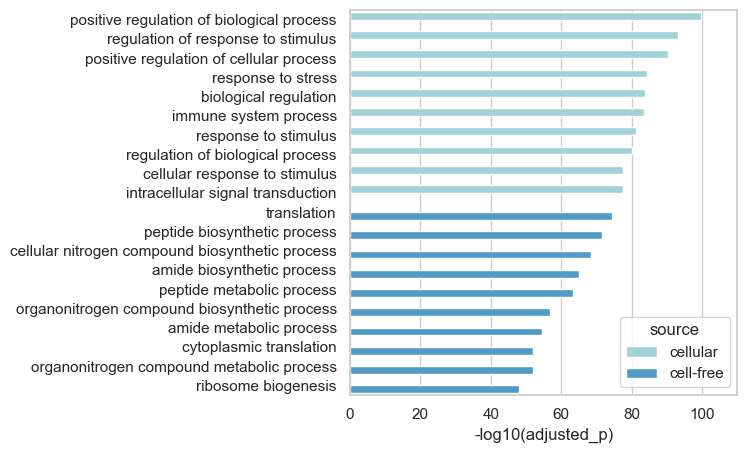

In [13]:
plt.figure(figsize = (5, 5))

sns.barplot(data = stone_deg,
            hue = 'source',
            x = '-log10(adjusted_p)',
            y = 'name',
            palette = biofluid_pal)

plt.xlim((0, 110))
plt.ylabel("")


#save_figure_pdf(plt, f"{figsave_path}stoneenrichment.pdf")

In [14]:
plasma_sed_LFC = up_dict['plasma_sediment_all_bioivt_urine'].trueLFC.values.tolist() + down_dict['plasma_sediment_all_bioivt_urine'].trueLFC.values.tolist()
plasma_sed_LFC = np.asarray(plasma_sed_LFC)

In [15]:
plasma_supt_LFC = up_dict['plasma_supt_all_bioivt_urine'].trueLFC.values.tolist() + down_dict['plasma_supt_all_bioivt_urine'].trueLFC.values.tolist()

plasma_supt_LFC = np.asarray(plasma_supt_LFC)

In [16]:
lfc_df = pd.DataFrame(data = plasma_supt_LFC,
                      columns = ['cell-free'])

lfc_df2 = pd.DataFrame(plasma_sed_LFC,
                       columns = ['cellular'])




In [17]:
lfc_df = pd.concat([lfc_df, lfc_df2])
lfc_df = pd.melt(lfc_df)
lfc_df.dropna(inplace = True)

(-15.0, 15.0)

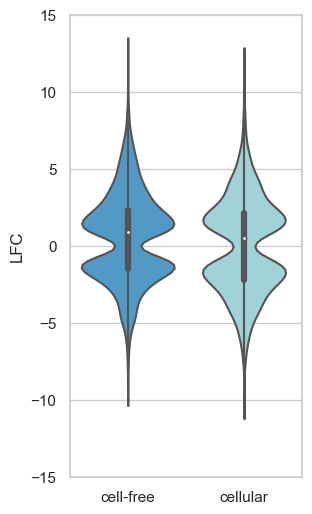

In [18]:
plt.figure(figsize = (3, 6))
sns.violinplot(x = 'variable',
               y= 'value',
               data = lfc_df,
               palette = biofluid_pal)
plt.ylabel("LFC")
plt.xlabel("")
plt.ylim((-15, 15))
#save_figure_pdf(plt, f'{figsave_path}violin_sedsuptVsPlasma.pdf')

In [19]:
np.median(plasma_sed_LFC[plasma_sed_LFC > 0])

2.138843041308869

In [20]:
np.median(plasma_sed_LFC[plasma_sed_LFC < 0])

-2.2057021903272074

# intersect cell type signatures with the differentially expressed genes in either supt or sediment

In [21]:
cell_sig_df = pd.read_csv("../data/rna_seq_cts/celltype_sigs.csv")
allSigs = {}
for ct in cell_sig_df.columns:
    allSigs[ct] = cell_sig_df[ct].dropna().values.tolist()

**this is plasma vs urine**

In [22]:
# these were the results on 'all_bioivt_urine_degDEG95CI.csv'

# commented out print commands correspond to the gene lists that were fed to 
# gProfiler online


deg_home = '../data/diffex/plasma_urine/95_ci/'

deg_dict = {}
for file in os.listdir(deg_home):
    comparison = pd.read_csv(f'{deg_home}{file}',
                            sep = ",", index_col = 0)
    if "20231228" in file:
        
        comparison = comparison[comparison.passed == True]
        comparison_name = file.split("20231228_")[1].split("_bioivt")[0]
        
        print(comparison_name)
        # want the DEG down genes, this is what's enriched in either urine
        # fraction relative to plasma
        comparison_down = comparison[comparison.trueLFC < 0]
        deg_dict[comparison_name] = comparison_down


plasma_sediment = deg_dict['plasma_sediment_normal'].genes.values.tolist()
plasma_supt = deg_dict['plasma_supt_normal'].genes.values.tolist()

plasma_supt_all
plasma_supt_normal
plasma_sediment_normal
plasma_sediment_all


In [23]:
sed_up = gp.profile(organism='hsapiens',
          query = plasma_sediment)

supt_up = gp.profile(organism = 'hsapiens',
                    query = plasma_supt)

In [24]:
sed_up['negative_log10_of_adjusted_p_value'] = -1 * np.log10(sed_up.p_value)
supt_up['negative_log10_of_adjusted_p_value'] = -1 * np.log10(supt_up.p_value)

In [25]:
sed_up['term_name'] = sed_up.name
supt_up['term_name'] = supt_up.name

In [26]:
# isolate the KEGG pathway enrichments
cols_for_hypergeom = ['term_size', 'query_size',
                     'intersection_size', 'effective_domain_size']

sed_up_kegg = sed_up[sed_up['source'] == 'KEGG'][['term_name', 'negative_log10_of_adjusted_p_value'] + cols_for_hypergeom]
supt_up_kegg = supt_up[supt_up.source == 'KEGG'][['term_name', 'negative_log10_of_adjusted_p_value'] + cols_for_hypergeom]


# add the biofluid information
sed_up_kegg['biofluid'] = 'sed_up'
supt_up_kegg['biofluid'] = 'supt_up'

# knit together
urine_degs = pd.concat([sed_up_kegg, supt_up_kegg])

In [27]:
# read in metabolomics enrichment results
metabo_kegg_pathways = pd.read_csv("../data/metaboanalyst/20230813_metaboanalyst_enrichmentanalysis/msea_ora_result.csv",
                                  sep = ",", index_col = 0)
metabo_kegg_pathways.head()

metabo_kegg_pathways.index.name = 'term_name'
metabo_kegg_pathways.reset_index(inplace = True)

metabo_kegg_pathways['biofluid'] = 'metabolome'

# viz of the pathway enrichment separately for transcriptomics

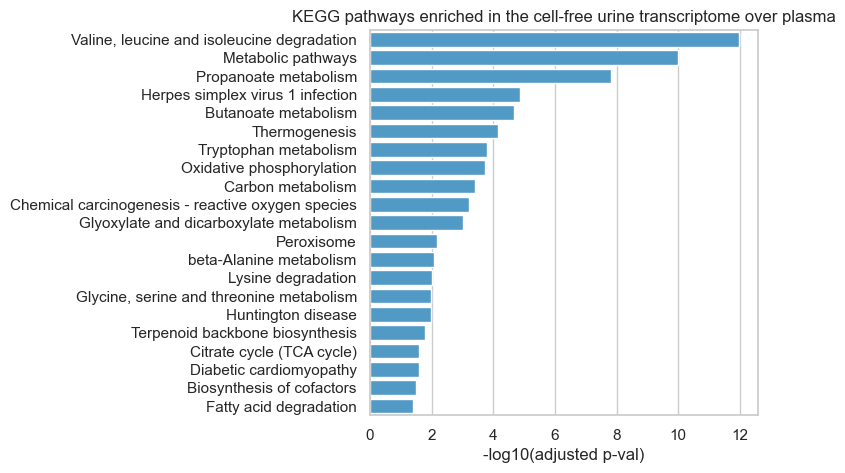

In [28]:
plt.figure(figsize = (5 ,5))
sns.barplot(x = 'negative_log10_of_adjusted_p_value',
           y = 'term_name',
           data = supt_up_kegg,
           color = biofluid_pal['cell-free'])
plt.ylabel("")
plt.xlabel("-log10(adjusted p-val)")
plt.title('KEGG pathways enriched in the cell-free urine transcriptome over plasma');
#save_figure_pdf(plt, f'{figsave_path}cellfreeVSPLASMA_pathwayenrichment.pdf')

Text(0.5, 1.0, 'KEGG Pathways Enriched in the cellular urine transcriptome over plasma')

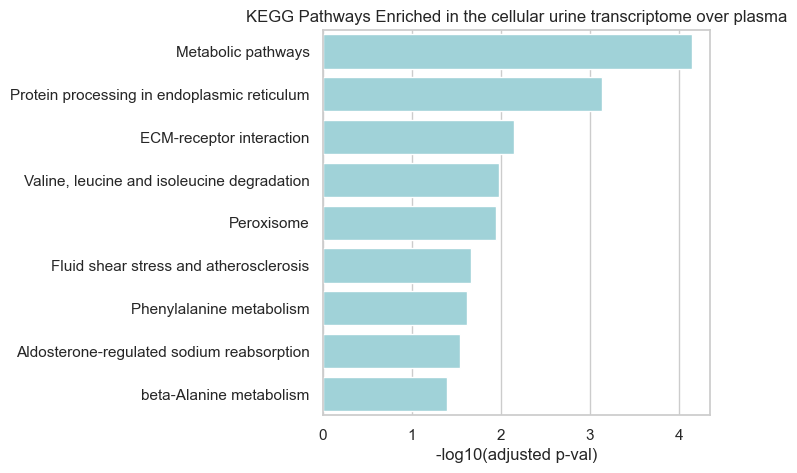

In [29]:
plt.figure(figsize = (5 ,5))
sns.barplot(x = 'negative_log10_of_adjusted_p_value',
           y = 'term_name',
           data = sed_up_kegg,
           color = biofluid_pal['cellular'])
plt.ylabel("")
plt.xlabel("-log10(adjusted p-val)")
plt.title('KEGG Pathways Enriched in the cellular urine transcriptome over plasma')
#save_figure_pdf(plt, f'{figsave_path}cellularVSPLASMA_pathwayenrichment.pdf')

In [30]:
sed_up_kegg.set_index("term_name", inplace = True)
supt_up_kegg.set_index("term_name", inplace = True)

In [31]:
joint = pd.concat([supt_up_kegg.head(10), sed_up_kegg.head(10)])

In [32]:
test = joint[['biofluid', 'negative_log10_of_adjusted_p_value']].reset_index()

In [33]:
test = test.pivot(index = 'term_name', columns = 'biofluid').fillna(0)

In [34]:
test = test.sort_values(by = ('negative_log10_of_adjusted_p_value', 'sed_up'),
                ascending = False)
                        

Text(0.5, 77.10937499999999, '')

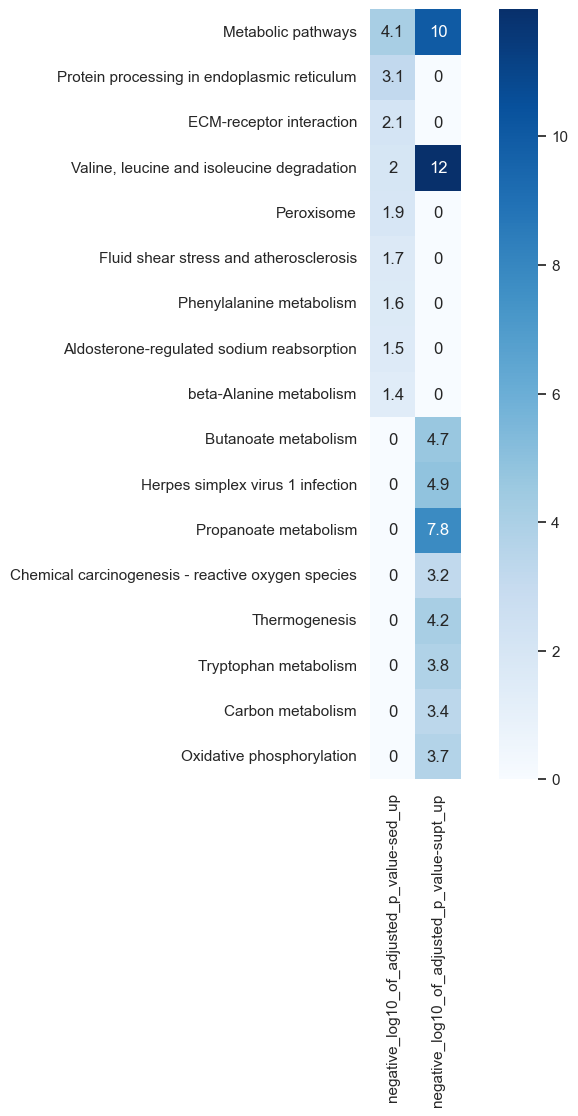

In [35]:
plt.figure(figsize = (10, 10))
sns.heatmap(test,
           cmap = 'Blues',
            square = True,
             #linewidths = 0.25,
            #linecolor ='black',
            annot = True)
plt.ylabel("")
plt.xlabel("")
#save_figure_pdf(plt, f'{figsave_path}hmap_GOEnrichment_urineVsPlasma.pdf')

In [36]:
joint.reset_index(inplace = True)

In [37]:
joint.sort_values(by = 'negative_log10_of_adjusted_p_value',
                 inplace = True,
                 ascending = False)

In [38]:
biofluid_pal['sed_up'] = biofluid_pal['supt']
biofluid_pal['supt_up'] = biofluid_pal['sediment']

In [39]:
joint.set_index("term_name", inplace = True)

In [40]:
-np.log10(0.05)

1.3010299956639813

# compute raw p values on the transcriptomic data; gProfiler only returns adjusted p values; need to adjust metabolomics and RNA p values together

In [41]:
# perform hypergeometric test/one-sided fisher exact test
# to get the p-value associated with the observed enrichment of the DEG with
# a given KEGG pathway

M_vals = urine_degs.effective_domain_size.values.tolist()
N_vals = urine_degs.query_size.values.tolist()
n_vals = urine_degs.term_size.values.tolist()
x_vals = urine_degs.intersection_size.values.tolist()

hypergeom_p = []

# hypergeom(M, n, N).sf(x) is the survival function and is generally
# equivalent to 1 - CDF
for idx, x in enumerate(x_vals):
    hypergeom_p += [hypergeom(M_vals[idx], n_vals[idx], N_vals[idx]).sf(x - 1)]
    

urine_degs['Raw p'] = hypergeom_p

In [42]:
# subset metabolomics and urine to the same DEGs
metabo_subset = metabo_kegg_pathways.loc[:, ['term_name', 'Raw p', 'biofluid']]

urine_degs = urine_degs[['term_name', 'Raw p', 'biofluid']]

In [43]:
all_pathway_enrichment = pd.concat([urine_degs, metabo_subset])

In [44]:
reject, adj_p, a, b = smt.multipletests(all_pathway_enrichment['Raw p'],
                            alpha = 0.05,
                            method = 'fdr_bh', 
                            is_sorted = False,
                            returnsorted = False)

all_pathway_enrichment['adjusted_p'] = adj_p

In [45]:
pval_thresh = 0.1

all_pathway_enrichment = all_pathway_enrichment[all_pathway_enrichment.adjusted_p < pval_thresh]
all_pathway_enrichment['negative_log10_of_adjusted_p_value'] = -1 * np.log10(all_pathway_enrichment.adjusted_p)

In [46]:
repeats = all_pathway_enrichment.loc[all_pathway_enrichment.duplicated(subset='term_name',
                                                       keep=False)]
#repeats = repeats[repeats.metabolome != 0]
repeats = repeats[repeats.term_name != 'Metabolic pathways']

repeats = repeats.pivot(index = 'term_name', columns = 'biofluid',
             values = 'negative_log10_of_adjusted_p_value')
repeats.fillna(0, inplace = True)

repeats = repeats[repeats.metabolome != 0]
repeats.reset_index(inplace = True)
repeats.sort_values(by = 'supt_up',
                    inplace = True)
my_range = range(repeats.shape[0])

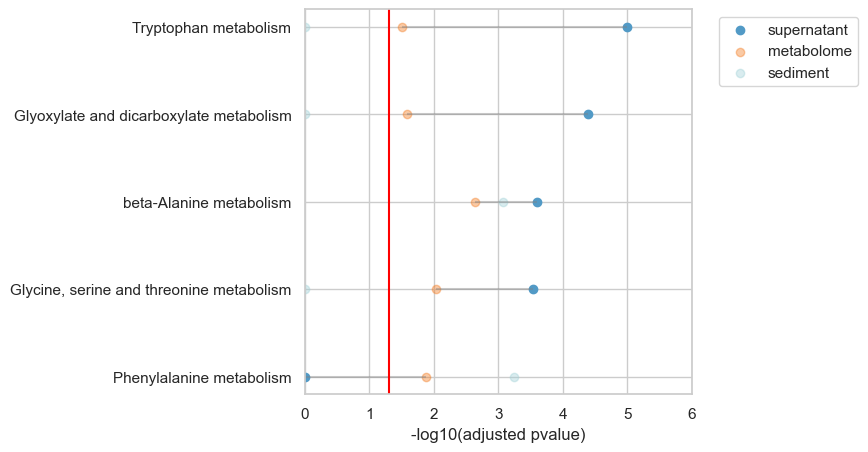

In [47]:
plt.figure(figsize = (5, 5))
plt.hlines(y = my_range,
           xmin = repeats.supt_up.values.tolist(), 
           xmax = repeats.metabolome,
           color = 'grey',
           alpha=0.4)

plt.scatter(repeats['supt_up'],
             my_range,
            color ='#529AC6', alpha=1,
            label = 'supernatant')

plt.scatter(repeats['metabolome'],
            my_range,
            color = '#F47B20',
            alpha=0.4 ,
            label = 'metabolome')

plt.scatter(repeats['sed_up'],
            my_range,
            color = '#A0D1D7',
            alpha=0.4 ,
            label = 'sediment')

plt.yticks(my_range, repeats.term_name)
plt.xticks()
plt.xlim((0, 6))
plt.xlabel('-log10(adjusted pvalue)')
plt.legend(bbox_to_anchor = (1.05, 1))
plt.axvline(color = 'red', x = -1 * np.log10(0.05))

#save_figure_pdf(plt, f'{figsave_path}20231228_pathwayenrichment.pdf')

# general metabolite pathway enrichment

In [48]:
adj_bh_thresh = 0.05

# do BH correction on the p vals
metabo_kegg_pathways = mh_correct(metabo_kegg_pathways, 'Raw p')

# apply adj p val thresh
metabo_kegg_pathways = metabo_kegg_pathways[metabo_kegg_pathways.adjusted_p <= adj_bh_thresh]



Text(0.5, 1.0, 'Metaboanalyst 5.0 Significantly Enriched KEGG Pathways')

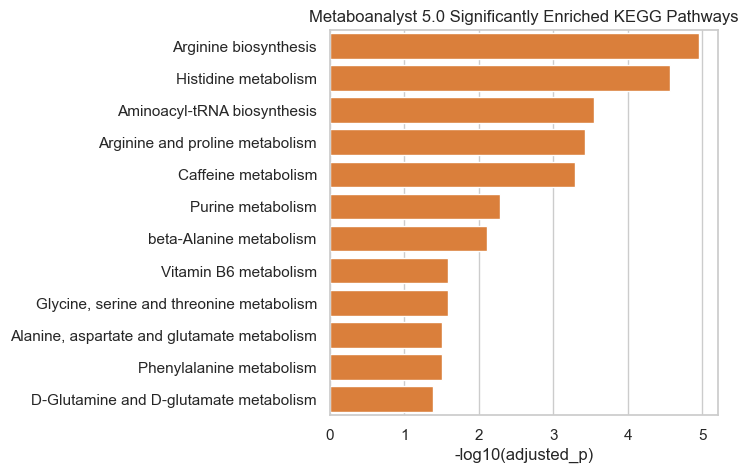

In [49]:

plt.figure(figsize = (5, 5))
sns.barplot(x = '-log10(adjusted_p)',
            y = 'term_name',
            color = biofluid_pal['metabolome'],
            data = metabo_kegg_pathways)
plt.ylabel("")
plt.title('Metaboanalyst 5.0 Significantly Enriched KEGG Pathways')

#save_figure_pdf(plt, f'{figsave_path}metabolite_pathwayenrichment.pdf')

# bulk level differential expression between urine sediment and supernatant

In [50]:
def celltype_hypergeom(deg_dict,
                   comparison,
                  ct_lst = allSigs.keys()):
    
    """
    Perform hypergeometric test for enrichment of cell types in
    specified DEG list.
    
    Inputs:
        deg_dict : 
        comparison (str): key of `deg_dict`
        
        ct_lst (list of str): cell types to perform hypergeom test on;
                              defaults to all cell types in the dictionary.
    
    Returns:
        hypergeom_data (pd.Dataframe())

    """
    
    # Universe is the size of specificity
    # of protein coding genes in HPA
    
    M = 3106 + 1628 + 6252 
        
    deg_df = deg_dict[comparison]
    N = deg_df.shape[0]
    
    hypergeom_data = []
    for s in ct_lst:
        n = allSigs[s]
        x = len(np.intersect1d(deg_df.genes, n))

        if x > 2:           
            p_val = hypergeom(M, len(n), N).sf(x - 1)
            print(s, p_val, M, len(n), N, x)
            hypergeom_data += [[s, x, p_val, comparison]]
    
    hypergeom_data = pd.DataFrame(hypergeom_data)
    
    if hypergeom_data.shape[0] == 0:
        print('there were no hits')
        return
    
    hypergeom_data.columns = ['cell_type', 'intersection_size',
                              'p_value', 'biofluid']

    
    return(hypergeom_data)

# do the cell type enrichment on urine cellular vs. cell-free DEGs

In [51]:
down_dict.keys()

dict_keys(['all_sed_supt', 'leukpos_sed_supt', 'leukneg_sed_supt', 'plasma_supt_all_bioivt_urine', 'plasma_supt_normal_bioivt_urine', 'plasma_sediment_normal_bioivt_urine', 'plasma_sediment_all_bioivt_urine'])

In [52]:
up_dict.keys()

dict_keys(['all_sed_supt', 'leukpos_sed_supt', 'leukneg_sed_supt', 'plasma_supt_all_bioivt_urine', 'plasma_supt_normal_bioivt_urine', 'plasma_sediment_normal_bioivt_urine', 'plasma_sediment_all_bioivt_urine'])

In [53]:
ct_lst = ['LE', 'bladder urothelial cell',
          'Proximal tubule']

hyper_urine_stone_up = celltype_hypergeom(up_dict, 
                                        'leukpos_sed_supt',
                                        ct_lst)

hyper_urine_stone_down = celltype_hypergeom(down_dict,
                                          'leukpos_sed_supt',
                                          ct_lst)


all_stone_urine = pd.concat([hyper_urine_stone_up, hyper_urine_stone_down],
                     axis = 0)

there were no hits
Proximal tubule 0.001568410290357291 10986 47 2458 20


In [54]:
all_stone_urine = mh_correct(all_stone_urine, 'p_value')

In [55]:
ct_lst = ['LE', 'bladder urothelial cell',
           'Proximal tubule']

hyper_urine_all_up = celltype_hypergeom(up_dict, 
                                        'all_sed_supt',
                                        ct_lst)

hyper_urine_all_down = celltype_hypergeom(down_dict,
                                          'all_sed_supt',
                                          ct_lst)


all_urine = pd.concat([hyper_urine_all_up, hyper_urine_all_down],
                     axis = 0)

there were no hits
LE 4.923060774427552e-07 10986 12 1748 10


In [56]:
all_urine = mh_correct(all_urine, 'p_value')

# do the cell type enrichment on urine vs. plasma DEGs

In [57]:
cell_lst = ['LE', 'bladder urothelial cell', 'Proximal tubule'] 

print('for sediment')
celltype_enrich_sediment = celltype_hypergeom(down_dict,
                                          'plasma_sediment_all_bioivt_urine',
                                          cell_lst)

print("")
print("for supernatant")
celltype_enrich_supt = celltype_hypergeom(down_dict,
                                      'plasma_supt_all_bioivt_urine',
                                      cell_lst)

# join two dataframes together and MH correct
celltype_enrich = pd.concat([celltype_enrich_sediment,
                      celltype_enrich_supt])

celltype_enrich = mh_correct(celltype_enrich,
                               'p_value')


# drop the p val <= 0.05
celltype_enrich = celltype_enrich[celltype_enrich.adjusted_p <= adj_bh_thresh]

for sediment
LE 0.11276796368218935 10986 12 1766 4
bladder urothelial cell 0.00043749542764910226 10986 20 1766 10
Proximal tubule 1.4707797466787786e-11 10986 47 1766 28

for supernatant
LE 6.984535789540785e-06 10986 12 3063 11
bladder urothelial cell 0.029482964181024886 10986 20 3063 10
Proximal tubule 1.2758873301097009e-06 10986 47 3063 29


In [58]:
cell_lst = ['LE', 'bladder urothelial cell', 'Proximal tubule'] #, 'Podocyte']

print('for sediment')
celltype_enrich_sediment = celltype_hypergeom(down_dict,
                                          'plasma_sediment_all_bioivt_urine',
                                          cell_lst)

print("")
print("for supernatant")
celltype_enrich_supt = celltype_hypergeom(down_dict,
                                      'plasma_supt_all_bioivt_urine',
                                      cell_lst)

# join two dataframes together and MH correct
celltype_enrich = pd.concat([celltype_enrich_sediment,
                      celltype_enrich_supt])

celltype_enrich = mh_correct(celltype_enrich,
                               'p_value')


# drop the p val <= 0.05
celltype_enrich = celltype_enrich[celltype_enrich.adjusted_p <= adj_bh_thresh]

for sediment
LE 0.11276796368218935 10986 12 1766 4
bladder urothelial cell 0.00043749542764910226 10986 20 1766 10
Proximal tubule 1.4707797466787786e-11 10986 47 1766 28

for supernatant
LE 6.984535789540785e-06 10986 12 3063 11
bladder urothelial cell 0.029482964181024886 10986 20 3063 10
Proximal tubule 1.2758873301097009e-06 10986 47 3063 29


In [59]:
#celltype_enrich.to_csv("../data/rna_seq_cts/enriched_celltypes.csv")

In [60]:
celltype_enrich

,cell_type,intersection_size,p_value,biofluid,adjusted_p,-log10(adjusted_p)
1,bladder urothelial cell,10,4.374954e-04,plasma_sediment_all_bioivt_urine,6.562431e-04,3.182935
2,Proximal tubule,28,1.470780e-11,plasma_sediment_all_bioivt_urine,8.824678e-11,10.054301
0,LE,11,6.984536e-06,plasma_supt_all_bioivt_urine,1.396907e-05,4.854832
1,bladder urothelial cell,10,2.948296e-02,plasma_supt_all_bioivt_urine,3.537956e-02,1.451248
2,Proximal tubule,29,1.275887e-06,plasma_supt_all_bioivt_urine,3.827662e-06,5.417066
